# Plan for ML
**Combination of Supervised and unsupervised**
**Using 2 times Random forest, 2 times PCA for ML. 1st time for feature selection, 2nd time for Actual Machine learning.

Step1. Feature Selection & Integration: Combining feature engineering using ML(Random forest, PCA)
- Statistical Filter
- Model Importance Filter
PCA (Dimension Reduction): By compressing variables such as AmountDisbursed, Interest, LoanLimit, and LoanBalance into a single dimension. which we can call "Debt Scale" simplify the model and improve its stability.

----------------------------------------- Fianl Data Frame ----------------------------------------- 

Step2. Data Imbalance Resolution [default:Non-default] by using SMOTE

Step3. K-Means Clustering: By training model with 3 different group; 'Low-Risk Group', 'Irregular Repayment Group', 'High-Risk New Entrants'

Step4. Actual ML Training
- Baseline: Random Forest
- Challenge: XGBoost
- Comparison: Logistic Regression

<class 'pandas.core.frame.DataFrame'>
Index: 1565 entries, 0 to 3469
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   LoanId                        1565 non-null   int64         
 1   AmountDisbursed               1565 non-null   int64         
 2   Interest                      1565 non-null   int64         
 3   LoanBalance                   1565 non-null   float64       
 4   BorrowDate                    1565 non-null   datetime64[ns]
 5   Product                       1565 non-null   object        
 6   Branch                        1565 non-null   object        
 7   ClearDate                     1565 non-null   datetime64[ns]
 8   CustomerId                    1565 non-null   int64         
 9   Gender                        1565 non-null   object        
 10  LoanLimit                     1565 non-null   float64       
 11  CreditScore                   1565 

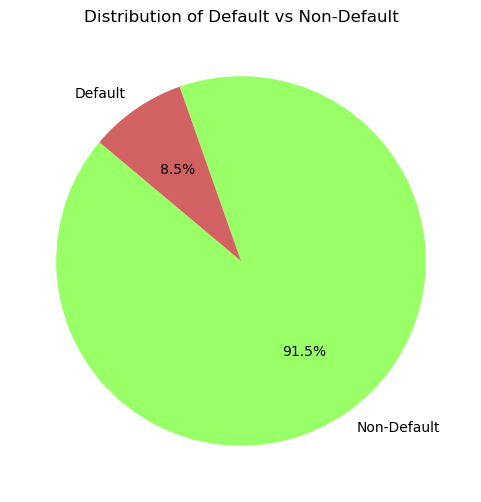

In [ ]:

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt 
import seaborn as sns

pd.set_option("display.max_columns", 100)

# Load the main dataset 
df = pd.read_csv('cleaned_dataset.csv')

# Display the first few rows of the dataset 
df.head()

# BorrowDate:  MM/DD/YYYY (Keep dayfirst=False)
df["BorrowDate"] = pd.to_datetime(df["BorrowDate"], errors="coerce", dayfirst=False)

# problematic columns: Use format='mixed' to handle the mix of DD/MM/YYYY and YYYY-MM-DD
df["loan_repayment_first_payment"] = pd.to_datetime(df["loan_repayment_first_payment"], errors="coerce", dayfirst=True, format='mixed')
df["loan_repayment_last_payment"] = pd.to_datetime(df["loan_repayment_last_payment"], errors="coerce", dayfirst=True, format='mixed')

# ClearDate:  YYYY-MM-DD
df["ClearDate"] = pd.to_datetime(df["ClearDate"], errors="coerce", format="%Y-%m-%d")

# More data cleaning 
# A customer cannot make a repayment 100 days BEFORE they borrowed the money.
# We allow a small buffer (-10 days) for potential booking errors, but anything less is garbage.
df['days_to_first'] = (df['loan_repayment_first_payment'] - df['BorrowDate']).dt.days
df = df[(df['days_to_first'] >= -10) | (df['days_to_first'].isna())].copy()

# The data logs the same loan twice. We keep only the first instance.
df = df.drop_duplicates(subset=['CustomerId', 'BorrowDate'], keep='first')

# A loan cannot be cleared BEFORE it was borrowed.
df = df[df['ClearDate'] >= df['BorrowDate']].copy()

# A business established in 2024 cannot borrow money in 2023.
df = df[df['YearEstablished'] <= df['BorrowDate'].dt.year].copy()

# Cleanup to remove Product types (sme - 3 months, sme - 4 months and 12 weeks credit ease) fron the dataset
df = df[~df['Product'].isin(['sme - 3 months', 'sme - 4 months', '12 weeks credit ease'])]
df.info()

# Drop unnecessary columns
columns_to_drop = ['LoanId']
df = df.drop(columns=columns_to_drop)

## Encoding
## Binary Encoding for Gener / Branch
df['Gender'] = df['Gender'].map({'male': 1, 'female': 0})
df['Branch'] = df['Branch'].map({'engineer': 1, 'molo': 0})

#2. Product type :  Use One-Hot Encoding. Since there are only 3 products, this won't create too many columns.
## prefix='Product' adds a label to the new columns for better organization
product_dummies = pd.get_dummies(df['Product'], prefix='Product')
df = pd.concat([df, product_dummies], axis=1) # Join the new columns back to the main dataframe
df = df.drop(columns=['Product']) # Drop the original 'Product' column (since it's now encoded)

#3. Industry & BusinessType: Use Frequency Encoding - replacing the name with its percentage in the dataset.
## This replaces the name with the percentage (0.0 to 1.0) of its occurrence
industry_freq = df['Industry'].value_counts(normalize=True)
df['Industry'] = df['Industry'].map(industry_freq)

## Frequency Encoding for BusinessType
business_type_freq = df['BusinessType'].value_counts(normalize=True)
df['BusinessType'] = df['BusinessType'].map(business_type_freq)

# Rate of loan utilized against the limit
df['Loan_Utilization'] = df['AmountDisbursed'] / df['LoanLimit']

df['IsDefault'] = ((df['ClearDate'] < '2025-12-15') & (df['LoanBalance'] > 0)).astype(int)

# Create a combined feature for Branch and BusinessType
branch_biz_risk = df.groupby(['Branch', 'BusinessType'])['IsDefault'].transform('mean')
df['Branch_Biz_Risk_Score'] = branch_biz_risk

# Business Age at the time of the loan
df['BusinessAge'] = df['BorrowDate'].dt.year - df['YearEstablished']

df.shape

# Understading the target variable Default where default is when ClearDate is greater than 2025-12-15 and LoanBalance is greater than 0
defaulters = ((df['ClearDate'] < '2025-12-15') & (df['LoanBalance'] > 0)).astype(int)
print("Number of defaulters:", defaulters.sum())

# Calculate the percentage of defaults vs non-defaults
default_counts = defaulters.value_counts(normalize=True) * 100
print("Percentage of Defaults vs Non-Defaults:\n", default_counts)

# Visualize the distribution of the target variable as a pie chart
plt.figure(figsize=(6, 6))
plt.pie(default_counts, labels=['Non-Default', 'Default'], autopct='%1.1f%%', startangle=140, colors=["#99ff66","#d26161"])
plt.title('Distribution of Default vs Non-Default')
plt.show()

In [29]:
print(df["Industry"].value_counts())
print(df["BusinessType"].value_counts())

Industry
0.589776    923
0.100319    157
0.081789    128
0.023642     74
0.041534     65
0.026837     42
0.021725     34
0.017252     27
0.014058     22
0.013419     21
0.012141     19
0.004473     14
0.008307     13
0.006390     10
0.005751      9
0.002556      4
0.001278      2
0.000639      1
Name: count, dtype: int64
BusinessType
0.314377    492
0.135463    212
0.088818    139
0.046006     72
0.045367     71
0.037061     58
0.014058     44
0.026837     42
0.026198     41
0.023003     36
0.021086     33
0.019169     30
0.017891     28
0.005751     27
0.016613     26
0.015335     24
0.007668     24
0.006390     20
0.012780     20
0.012141     19
0.011502     18
0.008946     14
0.008307     13
0.001278     12
0.002556     12
0.007029     11
0.004473      7
0.003834      6
0.000639      6
0.003195      5
0.001917      3
Name: count, dtype: int64


# Step1. Feature Selection & Integration

**Statistical Filter**
If Correlation > 0.1, it has correlation. if it is less than 0.1, it doensn't have correlation
Cross check correlation rate and VIF

**Model Importance Filter**
Check again using Random Forest. If freature importance is closer to 0, it means, feature doesn't have importance to IsDefault rate.

**So,When we choose the Feature**
Feature A: High Correlation + High importance
Feautre B: Medium,lower Correlation + High importance
Feature C: Lower correlation + Similar features(Which can combine using PCA)
Feature D: 0 Correlation, cannot explain why it's related to defaulty + 0 Importance

[Example]
Referring to below graph, Correlation rate and Importance rate has difference. So, we have to consider both correlation and importance when we choose the feature for ML

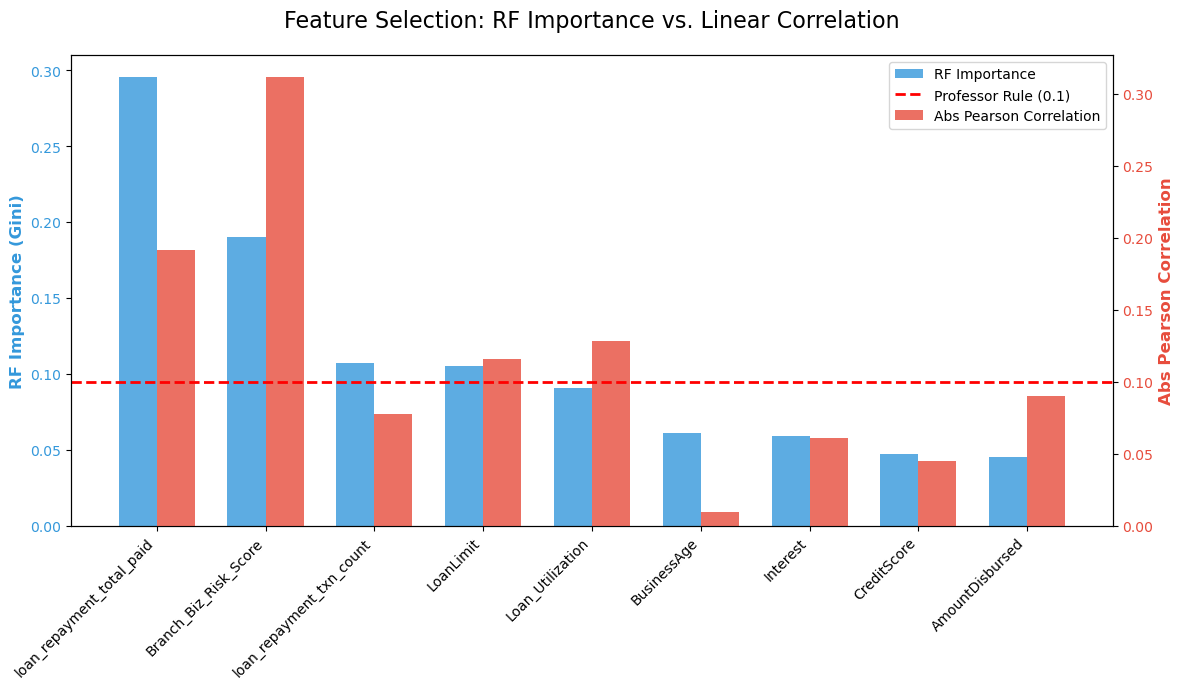

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# 1. Feature selection for analysis
feature_cols = ['Branch_Biz_Risk_Score', 'Loan_Utilization', 
    'CreditScore', 'BusinessAge', 'loan_repayment_txn_count', 'loan_repayment_total_paid',
    'AmountDisbursed', 'Interest', 'LoanLimit'
]

X = df[feature_cols]
y = df['IsDefault']

# 2. Correlation calculation
correlations = X.apply(lambda x: x.corr(y)).abs()

# 3. Random Forest importance calculation
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=feature_cols)

# 4. Combine results into a DataFrame for comparison
comparison_df = pd.DataFrame({
    'RF_Importance': importances,
    'Abs_Correlation': correlations
}).sort_values(by='RF_Importance', ascending=False)

# 5. Draw graph
fig, ax1 = plt.subplots(figsize=(12, 7))

# location for graph bars
x_axis = np.arange(len(comparison_df))
width = 0.35

# Bar1: Random Forest importance
bar1 = ax1.bar(x_axis - width/2, comparison_df['RF_Importance'], width, 
                label='RF Importance', color='#3498db', alpha=0.8)
ax1.set_ylabel('RF Importance (Gini)', color='#3498db', fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='#3498db')

# Bar2: Absolute Pearson Correlation
ax2 = ax1.twinx()
bar2 = ax2.bar(x_axis + width/2, comparison_df['Abs_Correlation'], width, 
                label='Abs Pearson Correlation', color='#e74c3c', alpha=0.8)
ax2.set_ylabel('Abs Pearson Correlation', color='#e74c3c', fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='#e74c3c')

# Professor's rule lines
ax2.axhline(y=0.1, color='red', linestyle='--', linewidth=2, label='Professor Rule (0.1)')

# Graph details
plt.title('Feature Selection: RF Importance vs. Linear Correlation', fontsize=16, pad=20)
ax1.set_xticks(x_axis)
ax1.set_xticklabels(comparison_df.index, rotation=45, ha='right')

# Legend combine
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.tight_layout()
plt.show()

/var/folders/8q/fl3wttwd7c7d86ktpbtwn_0m0000gn/T/ipykernel_5480/872545191.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


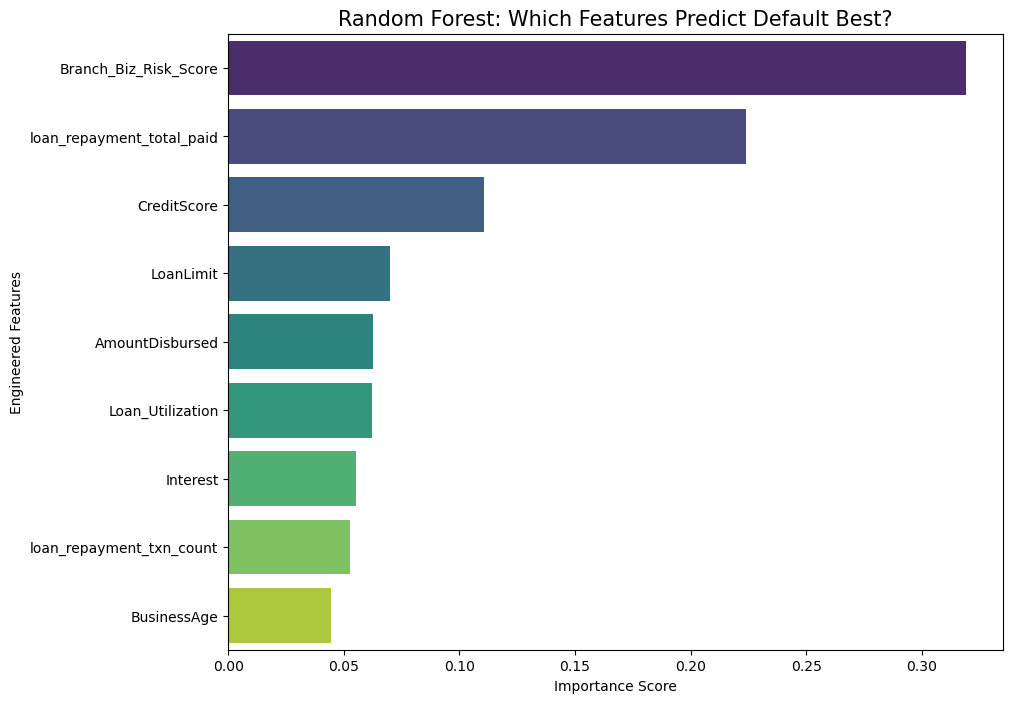

                     Feature  Importance
0      Branch_Biz_Risk_Score    0.319273
5  loan_repayment_total_paid    0.223823
2                CreditScore    0.110407
8                  LoanLimit    0.069808
6            AmountDisbursed    0.062404
1           Loan_Utilization    0.061953
7                   Interest    0.055225
4   loan_repayment_txn_count    0.052645
3                BusinessAge    0.044462


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# 1. Feature intergration
features = [
    'Branch_Biz_Risk_Score', 'Loan_Utilization', 
    'CreditScore', 'BusinessAge', 
    'loan_repayment_txn_count', 'loan_repayment_total_paid',
    'AmountDisbursed', 'Interest', 'LoanLimit'
]

X = df[features]
y = df['IsDefault']

# 2. Data divison (Train / Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Block SMOTE on training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 4. Training Random Forest
# add class_weight='balanced' to enhance model robustness
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train_resampled, y_train_resampled)

# 5. Visualize Feature Importance
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Random Forest: Which Features Predict Default Best?', fontsize=15)
plt.xlabel('Importance Score')
plt.ylabel('Engineered Features')
plt.show()

# Print importance dataframe
print(feature_importance_df)

In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Less important variables to combine via PCA
pca_targets = ['Interest', 'CreditScore', 'AmountDisbursed', 'LoanLimit']

# 2. Scaling (Essential for PCA)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[pca_targets])

# 3. PCA operation: Compress 4 variables into 1 'principal component'
pca = PCA(n_components=1)
df['PCA_Financial_Score'] = pca.fit_transform(scaled_features)

# 4. Drop the original columns used for PCA
df_final = df.drop(columns=pca_targets)

df['Financial_Risk_Index'] = pca.fit_transform(scaled_features)

# Step2. Balance overall data [default:Non-default]

**Our current dataset default:non-default rate is 8.5:91.5, which has high imbalanced rate between two**
Problem: IF IsDefault dataset is too low(8.5%), Machine has high potential to give up default data.

[Solution1 - SMOTE] - Default client, K-Nearest Neighbors, Synthetic creation
Solution: Create the Fake data for IsDefault rate using SMOTE(Synthetic Minority Over-sampling Technique), make a data balance between default and non-default. possible to learn details.
Caution: SMOTE only can use for [Train] model -> if it is used at test model, ML test fake dataset using fake data

[Solution2 - Class weights]
Solution: Keep the dataset, give more weight to 'default'. Trust of dataset is higher than SMOTE
Caution: If the weight of Default is too high, model can be sensitive to predict the result.


In [13]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# 1. Seperate Feature(X) and Target(y)
# Only numerical features are selected for SMOTE
features = ['Branch_Biz_Risk_Score', 'Loan_Utilization', 'CreditScore', 'BusinessAge']
X = df[features]
y = df['IsDefault']

# 2. Check original class distribution
print(f"Original class distribution: {y.value_counts().to_dict()}")

# 3. Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 4. Check resampled class distribution
print(f"Resampled class distribution: {y_resampled.value_counts().to_dict()}")

Original class distribution: {0: 1432, 1: 133}
Resampled class distribution: {0: 1432, 1: 1432}


**Result comparison**
SMOTE vs Class weights

Recall : Ability to identify actual positives (defaulters)
Precision : Accuracy of positive predictions
F1-Score : Balance between Precision and Recall

Most important result is 'recall' as our project goal is to identify as many defaulters as possible.
SMOTE > Class Weights in recall performance. as shown above.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# SMOTE data
rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_smote.fit(X_train_resampled, y_train_resampled)

print("\n=== [Method 2] SMOTE Results ===")
y_pred_smote = rf_smote.predict(X_test)
print(classification_report(y_test, y_pred_smote))

# Class weight
rf_weighted = RandomForestClassifier(
    n_estimators=100, 
    class_weight='balanced',
    random_state=42
)
rf_weighted.fit(X_train, y_train)

print("=== [Method 1] Class Weights Results ===")
y_pred_weights = rf_weighted.predict(X_test)
print(classification_report(y_test, y_pred_weights))



=== [Method 2] SMOTE Results ===
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       286
           1       0.63      0.70      0.67        27

    accuracy                           0.94       313
   macro avg       0.80      0.83      0.82       313
weighted avg       0.94      0.94      0.94       313

=== [Method 1] Class Weights Results ===
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       286
           1       0.67      0.30      0.41        27

    accuracy                           0.93       313
   macro avg       0.80      0.64      0.69       313
weighted avg       0.91      0.93      0.91       313



# Step3. K-Means Clustering
: Train AI to process clustering by themselves.

Cluster0: Prime Group (Low risk, low default rate)
Cluster1: At-Risk Group (Unpredictable repayment, Moderate default rate)
Cluster2: Critical Group (High risk, low repayment, High default rate)

-> IF AI finds highest average cluster of IsDefault, company has to focus on that 'high risk' cluster

--- Average per cluster ---
         Financial_Risk_Index  Branch_Biz_Risk_Score  Loan_Utilization  \
Cluster                                                                  
0                   -0.403071               0.049147          0.641332   
1                    4.419821               0.057534          0.597469   
2                   -0.523324               0.239209          0.681729   

         loan_repayment_total_paid  IsDefault  
Cluster                                        
0                      8376.036028   0.052724  
1                     27701.079710   0.014493  
2                      7119.785467   0.245675  


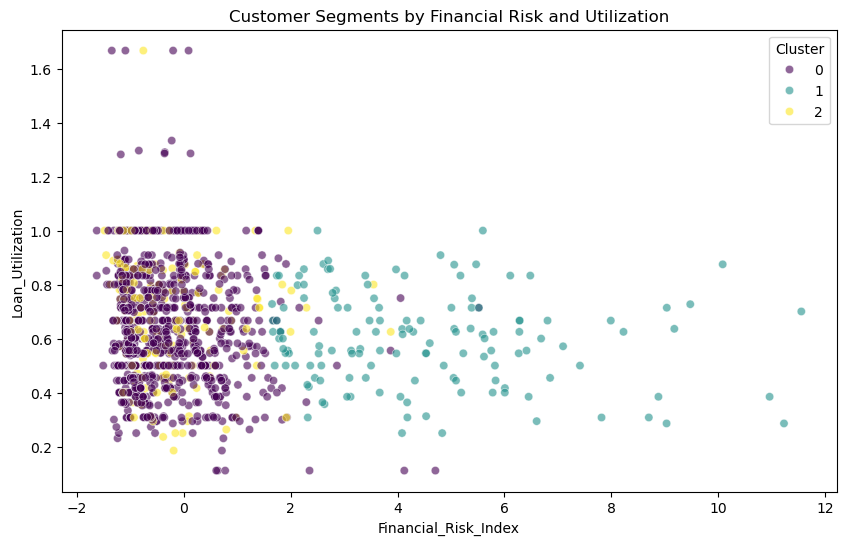

In [26]:
from sklearn.cluster import KMeans

# 1. Feature selection for clustering
# High importance features from previous analysis
cluster_features = [
    'Financial_Risk_Index',      # PCA combined variable
    'Branch_Biz_Risk_Score',     # Branch/Industry Risk
    'Loan_Utilization',          # Loan Utilization
    'loan_repayment_total_paid'  # Actual Repayment Ability
]

X_cluster = df[cluster_features]

# 2. Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# 3. K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# 4. Cluster summary
cluster_summary = df.groupby('Cluster')[cluster_features + ['IsDefault']].mean()
print("--- Average per cluster ---")
print(cluster_summary)

# 5. Financial_Risk_Index vs Loan_Utilization
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Financial_Risk_Index', y='Loan_Utilization', 
                hue='Cluster', palette='viridis', alpha=0.6)
plt.title('Customer Segments by Financial Risk and Utilization')
plt.show()

# Step4. Actual Machine Learning process
- Baseline: Random Forest
- Challenge: XGBoost (Increasing the percision)
- Comparison: Logistic Regression